In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
import torch
import yaml
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision import transforms
from PIL import Image
from pathlib import Path
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import kagglehub
path = kagglehub.dataset_download("cybersimar08/drone-detection")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/drone-detection


In [4]:
dataset_dir = path + "/drone-detection-new.v5-new-train.yolov8"

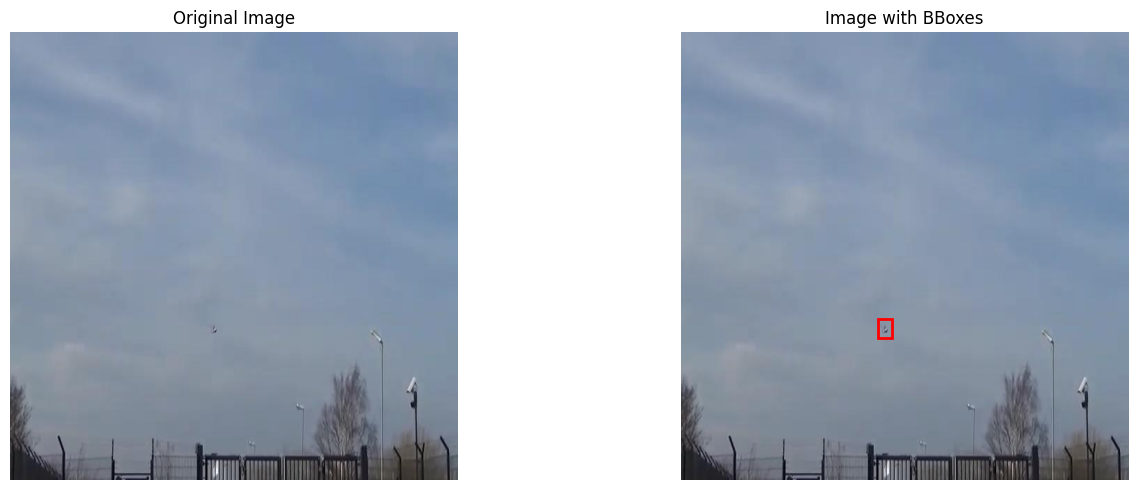

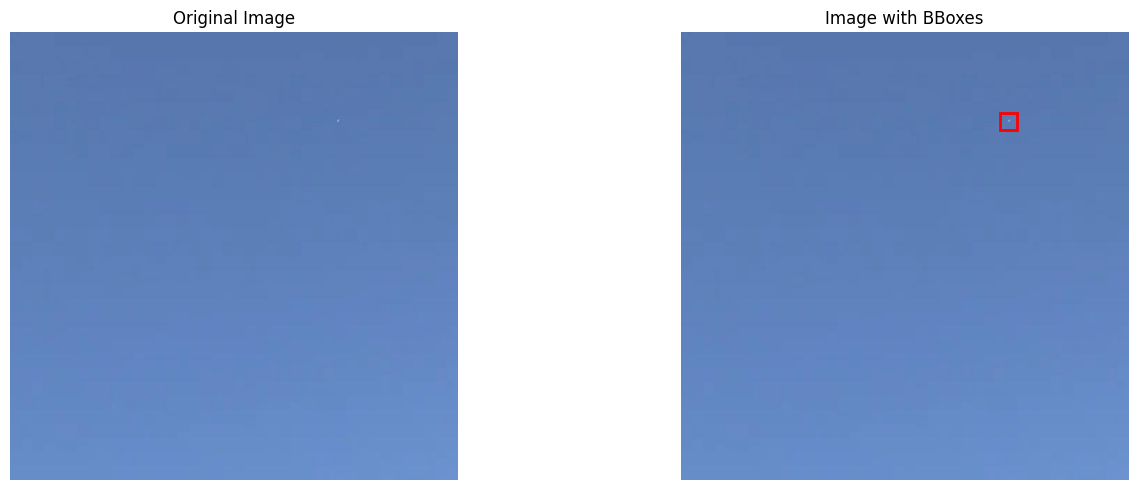

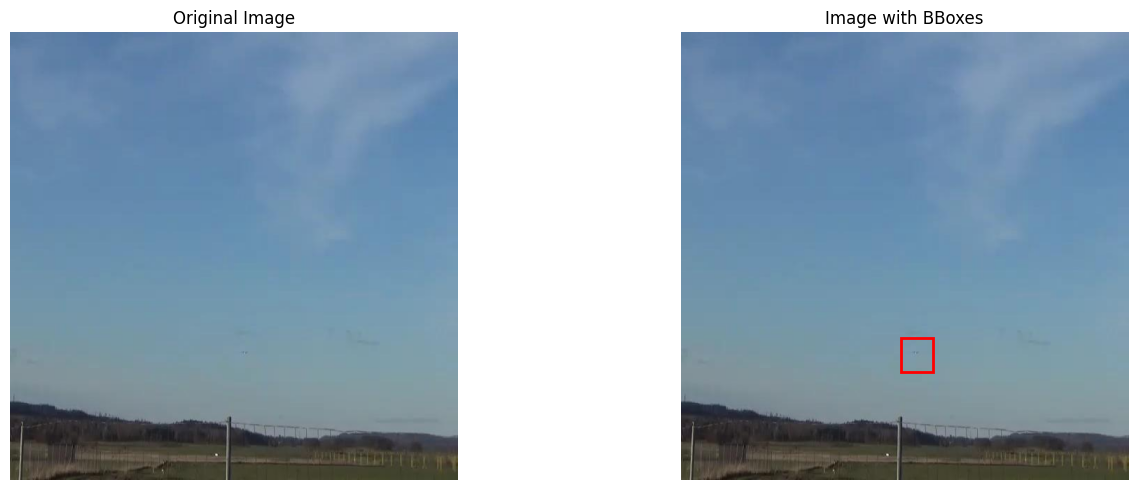

In [5]:
# check dataset
def imshow(dataset_dir: str, idx: int):
    dataset_path = Path(dataset_dir)
    image_path = list((dataset_path / "images").iterdir())[idx]
    labels = {}
    for label_path in (dataset_path / "labels").iterdir():
        labels[label_path.stem] = label_path
    label_path = labels[image_path.stem]

    image = Image.open(image_path).convert("RGB")
    npimg = np.array(image)
    height, width = npimg.shape[0], npimg.shape[1]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(npimg)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    axes[1].imshow(npimg)
    with open(label_path, "r") as f:
        for line in f:
            class_id, xc, yc, w, h = line.strip().split()
            xc, yc, w, h = map(float, [xc, yc, w, h])
            class_id = int(class_id)
            xc_abs = xc * width
            yc_abs = yc * height
            w_abs = w * width
            h_abs = h * height
            xmin = xc_abs - w_abs / 2
            ymin = yc_abs - h_abs / 2
            rect = patches.Rectangle(
                (xmin, ymin),
                w_abs,
                h_abs,
                linewidth=2,
                edgecolor="red",
                facecolor="none"
            )
            axes[1].add_patch(rect)
    axes[1].axis("off")
    axes[1].set_title("Image with BBoxes")

    plt.tight_layout()
    plt.show()


n_show = 3
for i in range(n_show):
    imshow(dataset_dir + "/train", i + 10)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
def create_config():
    config_data = {
        "path": f"{dataset_dir}/",
        "train": "train",
        "val": "valid",
        "names": ["AirPlane", "Drone", "Helicopter"]
    }
    config_path = "dataset_config.yaml"
    with open(config_path, "w") as f:
        yaml.dump(config_data, f, sort_keys=False)
    return os.path.abspath(config_path)

In [8]:
def train_yolo(model_cfg="yolov8n.yaml",
               data_cfg="settings.yaml",
               epochs=1,
               imgsz=640,
               batch=8,
               device="cuda"):
    model = YOLO(model_cfg).to(device)
    config = {
        "data": data_cfg,
        "epochs": epochs,
        "imgsz": imgsz,
        "batch": batch,
        "device": device,
        "plots": False,
        "save_json": True,
        "exist_ok": True
    }
    results = model.train(**config)
    return model, results


In [9]:
# train model
model, results = train_yolo(
        model_cfg='yolov8n.yaml',
        data_cfg=str(create_config()),
        epochs=10,
        device=device
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=False, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, 

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 372MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5.3±1.9 MB/s, size: 16.4 KB)


train: Scanning /kaggle/input/drone-detection/drone-detection-new.v5-new-train.yolov8/train/labels... 10799 images, 1979 backgrounds, 0 corrupt: 100%|██████████| 10799/10799 [00:58<00:00, 183.36it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/drone-detection/drone-detection-new.v5-new-train.yolov8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8.2±2.5 MB/s, size: 20.9 KB)


val: Scanning /kaggle/input/drone-detection/drone-detection-new.v5-new-train.yolov8/valid/labels... 603 images, 110 backgrounds, 0 corrupt: 100%|██████████| 603/603 [00:03<00:00, 188.88it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/drone-detection/drone-detection-new.v5-new-train.yolov8/valid is not writeable, cache not saved.


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.11G      2.691      6.406      2.726          6        640: 100%|██████████| 1350/1350 [03:36<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  6.32it/s]


                   all        603        497      0.223      0.351      0.176     0.0679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.36G      1.919      2.176      1.768          5        640: 100%|██████████| 1350/1350 [03:33<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.47it/s]

                   all        603        497      0.454      0.458       0.39      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.38G       1.83      1.873      1.673          6        640: 100%|██████████| 1350/1350 [03:32<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  7.89it/s]

                   all        603        497      0.343       0.55      0.388      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.39G      1.756      1.691      1.617          5        640: 100%|██████████| 1350/1350 [03:31<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  7.91it/s]

                   all        603        497      0.528      0.638      0.607        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.41G      1.713       1.54      1.569          5        640: 100%|██████████| 1350/1350 [03:28<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.67it/s]

                   all        603        497      0.661      0.682      0.693       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.43G      1.666      1.411      1.532          5        640: 100%|██████████| 1350/1350 [03:26<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  8.09it/s]

                   all        603        497      0.669      0.718      0.742      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.45G      1.628      1.321      1.496          4        640: 100%|██████████| 1350/1350 [03:25<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.86it/s]

                   all        603        497      0.783      0.769      0.828      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.46G        1.6      1.237      1.478          5        640: 100%|██████████| 1350/1350 [03:30<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.66it/s]

                   all        603        497      0.773      0.797      0.844      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.48G      1.569      1.191      1.456          5        640: 100%|██████████| 1350/1350 [03:30<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  8.17it/s]

                   all        603        497      0.817      0.824      0.854      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.49G      1.533      1.133      1.433          6        640: 100%|██████████| 1350/1350 [03:29<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.72it/s]

                   all        603        497      0.842      0.848      0.884      0.502



10 epochs completed in 0.601 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  9.17it/s]


                   all        603        497      0.838      0.848      0.882      0.501
              AirPlane        133        133      0.826      0.865      0.906      0.588
                 Drone        220        224      0.815      0.807      0.813      0.378
            Helicopter        140        140      0.874      0.871      0.927      0.535
Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Saving runs/detect/train/predictions.json...
Results saved to runs/detect/train


In [10]:
metrics = {
    'precision': results.results_dict['metrics/precision(B)'],
    'recall': results.results_dict['metrics/recall(B)'],
    'mAP50': results.results_dict['metrics/mAP50(B)'],
    'mAP50-95': results.results_dict['metrics/mAP50-95(B)']
}
for key, metric in metrics.items():
    print(f'{key}: {metric}')

precision: 0.8383263428813926
recall: 0.8477980317892598
mAP50: 0.882014591864047
mAP50-95: 0.5005470440485986


In [11]:
def plot_predictions(model, image_path, conf_thresh=0.5):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]
    results = model.predict(image, imgsz=640, conf=conf_thresh)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()
        cls_id = int(box.cls[0].cpu().numpy())
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="lime",
            facecolor="none"
        )
        class_name = model.model.names[cls_id]
        label = f"{class_name} {conf:.2f}"
        ax.text(
            x1,
            y1 - 10,
            label,
            color="lime",
            fontsize=12,
            backgroundcolor="black"
        )
        ax.add_patch(rect)
    plt.axis("off")
    plt.title("YOLO Predictions")
    plt.show()


0: 640x640 1 AirPlane, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


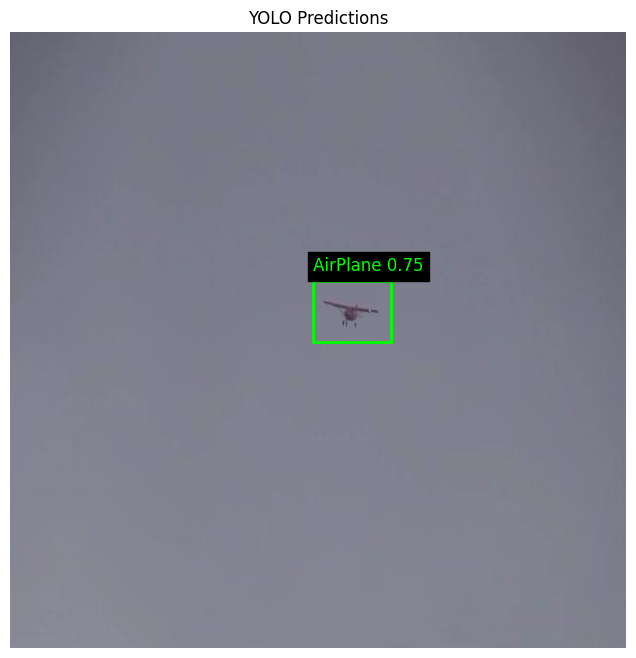

In [ ]:
# check some random detection
image_path = image_path = list((Path(dataset_dir) / "test/images").iterdir())[8]
plot_predictions(model, image_path, conf_thresh=0.5)